The purpose of this notebook is to create a critical pace + gradient (CPG) chart. That is, it will look at a (single) run, find the maximum speed at various gradients and time intervals, and plot it. I am treating the csv file as if it has 1-second recording turned on (even if it doesn't).

In [1]:
import pandas as pd
import numpy as np
import os

In [82]:
INDIR = r'data/csv/'

files = os.listdir(INDIR)

test_file = next(file for file in files if file.endswith(".csv")) 

df = pd.read_csv(INDIR + test_file)
df.head(10)

,Elevation,Timestamp,sec_elapsed,lat_lon,dist_delta_meters,elev_delta_meters,time_delta_sec,inst_speed_meters_sec,gradient
0,71.0,2018-01-24 02:25:11,0.0,"(33.739077999999999, -117.764537)",0.000000,0.0,0.0,0.000000,0.000000
1,71.0,2018-01-24 02:25:12,1.0,"(33.739069999999998, -117.76453600000001)",0.892167,0.0,1.0,0.892167,0.000000
2,71.0,2018-01-24 02:25:21,10.0,"(33.738911999999999, -117.76442400000001)",20.367657,0.0,9.0,2.263073,0.000000
3,71.0,2018-01-24 02:25:23,12.0,"(33.738874000000003, -117.764402)",4.682013,0.0,2.0,2.341006,0.000000
4,71.0,2018-01-24 02:25:27,16.0,"(33.738781000000003, -117.764371)",10.707868,0.0,4.0,2.676967,0.000000
5,71.0,2018-01-24 02:25:28,17.0,"(33.738757999999997, -117.76436200000001)",2.683970,0.0,1.0,2.683970,0.000000
6,71.0,2018-01-24 02:25:29,18.0,"(33.738734000000001, -117.764352)",2.818701,0.0,1.0,2.818701,0.000000
7,71.0,2018-01-24 02:25:30,19.0,"(33.738711000000002, -117.76434399999999)",2.656636,0.0,1.0,2.656636,0.000000
8,70.7,2018-01-24 02:25:39,28.0,"(33.738526999999998, -117.764252)",22.117910,-0.3,9.0,2.457546,-0.013564
9,70.3,2018-01-24 02:25:46,35.0,"(33.738399999999999, -117.764191)",15.178380,-0.4,7.0,2.168340,-0.026353


In [83]:
df['gradient'].describe()

count    282.000000
mean           -inf
std             NaN
min            -inf
25%       -0.019546
50%        0.000000
75%        0.022055
max        0.148826
Name: gradient, dtype: float64

We can see that there is a -np.inf value in the gradient. We'll replace it with 0.

In [85]:
df['gradient'].iloc[154] = 0.0

/Users/paulsavala/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [86]:
df['gradient'].describe()

count    282.000000
mean       0.000149
std        0.031571
min       -0.126480
25%       -0.019436
50%        0.000000
75%        0.022055
max        0.148826
Name: gradient, dtype: float64

Now that everything looks good with the gradient, we'll create a column where the gradient lies between $\pm 90$, which makes rounding simpler.

In [101]:
df['gradient_100'] = 100*df['gradient']

Now for a quick-and-dirty analysis, we can see the fastest pace for time intervals from 1 to 60 seconds.

In [9]:
best_pace = [max(df['inst_speed_meters_sec'].rolling(window=n).mean().fillna(0)) for n in np.arange(1,61)]

In [145]:
from matplotlib import pyplot as plt

%matplotlib inline

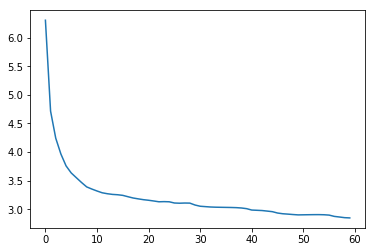

In [11]:
plt.plot(best_pace)

Next, we want to do this same thing, but for any gradient that we choose. The strategy will be to do rolling windows for the time requested, then calculate the gradients. This gives a vector with gradient and max speed. This can then be written into a numpy matrix with rows being gradient, and columns being time.

We'll start with a little test.

In [108]:
# time interval of 5 seconds chosen arbitrarily
rolling_5_df = df[['inst_speed_meters_sec', 'gradient_100']].rolling(window=5).mean().fillna(0)
rolling_5_df['rounded_gradient_100'] = rolling_5_df['gradient_100'].apply(np.round)

for name, group in rolling_5_df.groupby('rounded_gradient_100'):
    print(name, max(group['inst_speed_meters_sec']))
    
rolling_5_grouped = rolling_5_df.groupby('rounded_gradient_100')

-6.0 1.58690359006
-5.0 3.053217006
-4.0 3.10006969034
-3.0 3.75776998661
-2.0 3.20399990063
-1.0 3.27203974374
0.0 3.53753484996
1.0 3.17362308641
2.0 3.16931194627
3.0 2.99704279985
4.0 2.81628297596
5.0 2.64074250499


Now let's make this into a proper function.

In [8]:
# Note that this function accesses the dataframe df, so that must be defined ahead of time. Obviously this should 
# be fixed in the future.
def max_speed_t_g(t,g):
    rolling_df = df[['inst_speed_meters_sec', 'gradient_100']].rolling(window=t).mean().fillna(0)
    rolling_df['rounded_gradient_100'] = rolling_df['gradient_100'].apply(np.round)
    rolling_groupby = rolling_df.groupby('rounded_gradient_100')
    
    try:
        group_g = rolling_groupby.get_group(g)
        max_speed = max(group_g['inst_speed_meters_sec'])
    except KeyError:
        max_speed = 0
    return max_speed

max_speed_t_g_vec = np.vectorize(max_speed_t_g, otypes=[np.float64])

The most efficient way (I know of) to plot this is to do everything in numpy so that it's vectorized. We'll create a meshgrid with the time and gradients, and then apply our max_speed_t_g_vec (vectorized version) to it. This can then be directly plotted in Plotly.

In [142]:
t = np.arange(0, 300, 1)
g = np.arange(-10, 10, 1)
TT, GG = np.meshgrid(t, g)
ZZ = max_speed_t_g_vec(TT, GG)

In [143]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Surface(x=GG, y=TT, z=ZZ)
]

layout = go.Layout(
    title='Max speed',
    xaxis=dict(
        title='Gradient'
    ),
    yaxis=dict(
        title='Time interval (s)'
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Next, let's create functions which plot "slices" for different time or gradients.

In [150]:
t = np.arange(10,11) # Just the number 10
g = np.arange(-10, 10, 1)
TT, GG = np.meshgrid(t, g)

max_speed_10sec = max_speed_t_g_vec(TT,GG)

In [153]:
best_10sec = go.Scatter(x=g,y=max_speed_10sec)
data = [best_10sec]
py.iplot(data=data)

TypeError: iplot() missing 1 required positional argument: 'figure_or_data'

TESTING

In [3]:
ar1 = np.array([1,2,3])
ar2 = np.array([0,4,3])

In [5]:
np.maximum(ar1,ar2)

array([1, 4, 3])